# Φ<sub>Flow</sub> Cookbook

This notebook lists useful code snippets.

## Import for NumPy, TensorFlow, PyTorch, Jax

In [2]:
from phi.flow import *
from phi.tf.flow import *
from phi.jax.stax.flow import *
from phi.torch.flow import *

## Select GPU or CPU

In [2]:
gpus = backend.default_backend().list_devices('GPU')

assert backend.default_backend().set_default_device('CPU')


## Use 64 bit FP precision

In [3]:
math.set_global_precision(32)
x64 = math.random_normal(batch(b=4))

with math.precision(64):  ## operations within this context will use 32 bit floats
    x32 = math.to_float(x64)


## Plot a `Tensor`

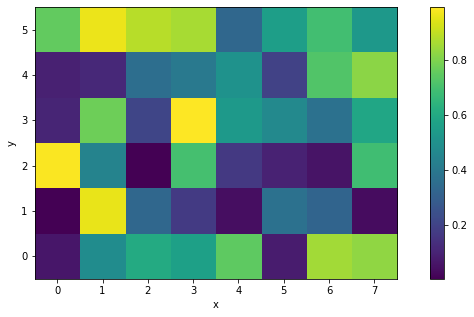

<Figure size 432x288 with 0 Axes>

In [5]:
data = math.random_uniform(spatial(x=8, y=6))
vis.plot(data)  ## or vis.show(data)


## Convert a `Tensor` to NumPy

In [ ]:
data.numpy(order='x,y')

## Compute Pair-wise Distances

In [ ]:
points = math.tensor([(0, 0), (0, 1), (1, 0)], instance('points'), channel('vector'))
distances = points - math.rename_dims(points, 'points', 'others')
math.print(distances)

## Construct a `CenteredGrid`

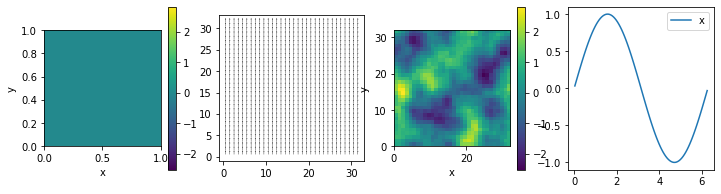

<Figure size 432x288 with 0 Axes>

In [3]:
zero_grid = CenteredGrid(0, 0, x=32, y=32, bounds=Box(x=1, y=1))
y_grid = CenteredGrid((0, 1), extrapolation.BOUNDARY, x=32, y=32)
noise_grid = CenteredGrid(Noise(), extrapolation.PERIODIC, x=32, y=32)
sin_curve = CenteredGrid(lambda x: math.sin(x), extrapolation.PERIODIC, x=100, bounds=Box(x=2 * PI))

vis.plot(zero_grid, y_grid, noise_grid, sin_curve, size=(12, 3))

## Construct a `StaggeredGrid`

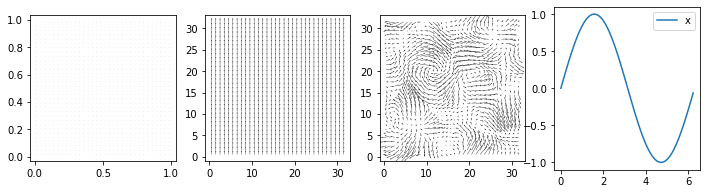

<Figure size 432x288 with 0 Axes>

In [4]:
zero_grid = StaggeredGrid(0, 0, x=32, y=32, bounds=Box(x=1, y=1))
y_grid = StaggeredGrid((0, 1), extrapolation.BOUNDARY, x=32, y=32)
noise_grid = StaggeredGrid(Noise(), extrapolation.PERIODIC, x=32, y=32)
sin_curve = StaggeredGrid(lambda x: math.sin(x), extrapolation.PERIODIC, x=100, bounds=Box(x=2 * PI))

vis.plot(zero_grid, y_grid, noise_grid, sin_curve, size=(12, 3))


## Construct `StaggeredGrid` from NumPy Arrays

Given matching arrays `vx` and `vy`, we can construct a `StaggeredGrid`.
Note that the shapes of the arrays must [match the extrapolation](https://tum-pbs.github.io/PhiFlow/Staggered_Grids.html)!

In [5]:
vx = math.tensor(np.zeros([33, 32]), spatial('x,y'))
vy = math.tensor(np.zeros([32, 33]), spatial('x,y'))
StaggeredGrid(math.stack([vx, vy], channel('vector')), extrapolation.BOUNDARY)

vx = math.tensor(np.zeros([32, 32]), spatial('x,y'))
vy = math.tensor(np.zeros([32, 32]), spatial('x,y'))
StaggeredGrid(math.stack([vx, vy], channel('vector')), extrapolation.PERIODIC)

vx = math.tensor(np.zeros([31, 32]), spatial('x,y'))
vy = math.tensor(np.zeros([32, 31]), spatial('x,y'))
StaggeredGrid(math.stack([vx, vy], channel('vector')), 0)


StaggeredGrid[(xˢ=32, yˢ=32, vectorᶜ=2), size=(x=32, y=32), extrapolation=0]

## BFGS Optimization

In [6]:
def loss_function(x):
    return math.l2_loss(math.cos(x))

initial_guess = math.tensor([1, -1], math.batch('batch'))
math.minimize(loss_function, Solve('L-BFGS-B', 0, 1e-3, x0=initial_guess))


(1.5739374160766602, -1.5739374160766602) along batchᵇ

## Linear Solve

In [7]:
def f(x):
    return 2 * x


math.solve_linear(f, 84, Solve('CG', 1e-5, 0, x0=0))


42.0

## Sparse Matrix Construction

In [8]:
from functools import partial

periodic_laplace = partial(math.laplace, padding=extrapolation.PERIODIC)
matrix = math.jit_compile_linear(periodic_laplace).sparse_matrix(math.zeros(spatial(x=5)), format='coo')  # csr, csc, coo
math.print(matrix.values)


(nnzⁱ=15)
  1.,  1., -2.,  1.,  1., -2.,  1.,  1., -2.,  1.,  1., -2.,  1.,  1., -2.


## Sampling a Function

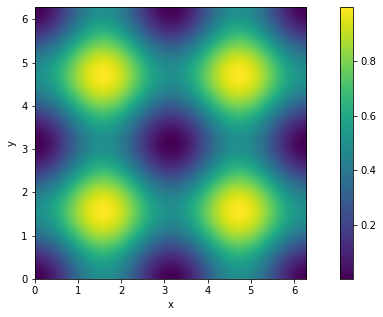

<Figure size 432x288 with 0 Axes>

In [9]:
def f(x):
    return math.l2_loss(math.sin(x))

f_grid = CenteredGrid(f, x=100, y=100, bounds=Box(x=2*PI, y=2*PI))
vis.plot(f_grid)

## Plot Optimization Trajectories

In [10]:
def minimize(x0):
    with math.SolveTape(record_trajectories=True) as solves:
        math.minimize(f, Solve('BFGS', 0, 1e-5, x0=x0))
    return solves[0].x  # shape (trajectory, x, y, vector)

trajectories = CenteredGrid(minimize, x=8, y=8, bounds=Box(x=2*PI, y=2*PI)).values
segments = []
for start, end in zip(trajectories.trajectory[:-1].trajectory, trajectories.trajectory[1:].trajectory):
    segments.append(PointCloud(start, end - start, bounds=Box(x=2*PI, y=2*PI)))
anim_segments = field.stack(segments, batch('time')).with_color('#FFFFFF')
vis.plot(vis.overlay(f_grid, *segments, anim_segments), animate='time', frame_time=500)

<Figure size 432x288 with 0 Axes>

## Neural Network Training

In [ ]:
net = dense_net(1, 1, layers=[8, 8], activation='ReLU')  # Implemented for PyTorch, TensorFlow, Jax-Stax
optimizer = adam(net, 1e-3)
BATCH = batch(batch=100)

def loss_function(data: Tensor):
    prediction = math.native_call(net, data)
    label = math.sin(data)
    return math.l2_loss(prediction - label), data, label

print(f"Initial loss: {loss_function(math.random_normal(BATCH))[0]}")
for i in range(100):
    loss, _data, _label = update_weights(net, optimizer, loss_function, data=math.random_normal(BATCH))
print(f"Final loss: {loss}")

## Parameter Count

In [ ]:
parameter_count(net)
